# Source Code for implementing ACO for the MAPF problem

* Create algorithm for ACO (done)
* Create test promles (done / more or less)
* Create algorithm for time-expansion of the graph (working)
* Create Multi-Agent-ACO solver

Working Title: "Converging Intent: Soving the Multi-Agent Path Finding Problem with Ant Colony Optimisation"

Abstract:
* ACO is used to solve path finding problems in graphs
* The pheromone-matrix represents the intent of an agent
* A solution to the MAPF can be viewed as a state of consent of intentions
* Two problems need to be solved: 
    * Time Extension of ACO
    * Ants that consider other agents intent
* Experiments: in progress
* Works?

In [1]:
# install the required packages
%pip install matplotlib pandas seaborn numpy networkx ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=np.inf)
import networkx as nx
import ipywidgets as widgets

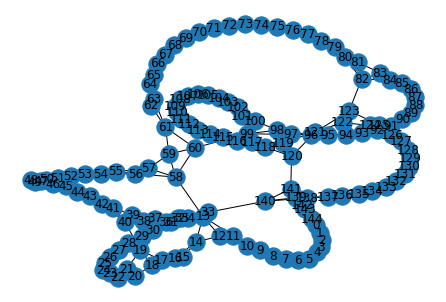

In [139]:
G = nx.watts_strogatz_graph(145,4, 0.01, seed=42)
nx.draw(G,with_labels=True)
for e in G.edges():
    G[e[0]][e[1]]['weight']= 0.5 + np.random.rand()
graphstart = 0
graphgoal = 75

In [140]:
class Ant:
    def __init__(self, start = 0, goal = None, pheromones = None, adjacency = None):
        self.start = start
        self.goal = goal
        self.pheromones = pheromones
        self.adjacency = adjacency
        self.stuck = False
        self.selection = self.ant_system_selection
        
        self.setup()
        
        
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize(self, value = 0.5):
        factor = 1 * self.pheromones.shape[0] / np.sum(self.pheromones)
        np.multiply(self.pheromones, factor, out=self.pheromones)
        
    def delayed_update(self):
        amount = 1/self.distance
        for i in range(len(self.path)-1):
            self.pheromones[self.path[i], self.path[i+1]] += amount #/ self.adjacency[self.path[i], self.path[i+1]]
            self.pheromones[self.path[i+1], self.path[i]] += amount #/ self.adjacency[self.path[i], self.path[i+1]]
            
    
    def random_selection(self, new):
        return np.random.choice(new)
    
    def value(self, i, j, alpha=0.5, beta=0.5, **kwargs):
        d = self.adjacency[i,j]
        return np.max([np.finfo(float).eps,self.pheromones[i,j]])**alpha * (1/d)**beta
    
    def ant_system_selection(self,state, new, **kwargs):
        probs = {k : self.value(state, k, **kwargs) for k in new }
        cutoff = np.random.rand()
        s = sum(probs.values())
        x = new[-1]
        for k, v in probs.items():
            cutoff -= v / s
            if cutoff < 0:
                return k
        if cutoff < 0:
            print(f"cutoff:{cutoff} < 0 - should not happen")
            print(probs)
        return x
    
    def get_time(self):
        return len(self.path)-1
    
    def roulette_wheel_selection(self, state ,new):
        probs = {k : self.pheromones[state, k] for k in new }
        cutoff = np.random.rand()
        s = sum(probs.values())
        x = new[-1]
        for k, v in probs.items():
            cutoff -= v / s
            if cutoff < 0:
                x = k
                break
        assert(cutoff <= 0)
        return x

    def setup(self, start=None, goal=None, **kwargs):
        if start:
            self.start = start
        if goal:
            self.goal = goal
        self.stuck = False
        self.state = self.start
        self.path = [self.start]
        self.distance = 0
            
    def step(self, selection=None, revisit_nodes=False, allow_wait=False, **kwargs):
        if selection:
            self.selection = selection
        if not self.selection:
            self.selection = self.ant_system_selection
        
        # compute next possible states $new
        new = [node for node in range(len(self.adjacency))]
        if not revisit_nodes:
            new = [node for node in new if not (node in self.path)]
        
        new = [node for node in new if not (self.adjacency[self.state, node] == 0)]
        
        if allow_wait:
            new.append(self.state)
        
        # in case no more states are possible: return
        if not new:
            self.stuck=True
            return
        
        # pick a new state from the list
        self.state = self.selection(self.state, new, **kwargs)
        self.path.append(self.state)
        d = self.adjacency[self.path[-2], self.path[-1]]
        #print(f"current distance: {d}")
        self.distance += d
        

class ACO:
    def __init__(self, start = 0, goal = None, pheromones = None, adjacency = None, **kwargs):
        self.start = start
        self.goal = goal
        self.pheromones = pheromones
        self.adjacency = adjacency
        self.best_distance = np.inf
        self.best_path = [start]
        self.kwargs = kwargs
        assert pheromones.shape == adjacency.shape
        for i in range(adjacency.shape[0]):
            for j in range(adjacency.shape[1]):
                if adjacency[i, j] == 0:
                    self.pheromones[i, j] = 0
        
        self.pheromone_timeline = [pheromones.copy()]
        self.distance_timeline = [self.best_distance]
        self.create_ants()

        
    def create_ants(self, num_ants = 10):
        self.ants = [Ant(start=self.start, goal=self.goal, pheromones=self.pheromones, adjacency=self.adjacency) for _ in range(num_ants)]
   
    def online_pheromone_update(self, **kwargs):
        for ant in self.ants:
            amount = 1 / self.adjacency[ant.path[-2],ant.path[-1]]
            self.pheromones[ant.path[-1], ant.path[-2]] += amount
            self.pheromones[ant.path[-2], ant.path[-1]] += amount
            
    def delayed_online_pheromone_update(self, **kwargs):
        for ant in self.ants:
            if ant.state == ant.goal:
                amount = 1 / ant.distance
                for i in range(len(ant.path) - 1):
                    self.pheromones[ant.path[i], ant.path[i+1]] += amount
                    self.pheromones[ant.path[i+1], ant.path[i]] += amount
    
    def penalize_stuck(self, stuck_penalty=0.1, **kwargs):
        for ant in self.ants:
            if ant.stuck:
                self.pheromones[ant.path[-1], ant.path[-2]] += -stuck_penalty
                self.pheromones[ant.path[-2], ant.path[-1]] += -stuck_penalty
        
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize(self, gamma = 1, **kwargs):
        factor = gamma * self.pheromones.shape[0] / np.sum(self.pheromones)
        np.multiply(self.pheromones, factor, out=self.pheromones)
        
        
    def step(self, **kwargs):
        for ant in self.ants:
            ant.step(**kwargs)

    def daemon_actions(self, reverse_ants=True, **kwargs):
        """perform daemon actions
        * Reset ants that have arrived
        
        Keyword Arguments:
        reverse_ants -- if True the goal and start will be swapped before the ant is reset
        """
        for ant in self.ants:
            if ant.stuck:
                ant.setup()
            if ant.state == ant.goal:
                if ant.distance < self.best_distance:
                    self.best_distance = ant.distance
                    self.best_path = ant.path
                if reverse_ants:
                    ant.goal, ant.start = ant.start, ant.goal
                ant.setup()
        self.distance_timeline.append(self.best_distance)
    
    
    def update_pheromones(self, delayed_update=True, evaporation_method="normalize", log_pheromones=True, penalize_stuck=False, elitist_update=False, **kwargs):
        """updates the pheromone matrix
    
        Keyword Arguments:
        delayed_update -- bool telling to perform the pheromone update after each step or when the ant reaches the goal
        evaporation_method -- tell the algorithm how to perform evaporation ("normalize" or "evaporate")
        gamma -- rate of evaporation (depends on evaporation_method)
        """
        if delayed_update:
            self.delayed_online_pheromone_update(**kwargs)
        else:
            self.online_pheromone_update(**kwargs)
        
        if elitist_update:
            amount = 1 / self.best_distance / self.num_ants
            for i in range(len(self.best_path) - 1):
                self.pheromones[self.best_path[i], self.best_path[i+1]] += amount
                self.pheromones[self.best_path[i+1], self.best_path[i]] += amount
                
        
        # evaporation
        if evaporation_method == "normalize":
            self.normalize(**kwargs)
        elif evaporation_method == "evaporate":
            self.evaporate(**kwargs)
        
        if penalize_stuck:
            self.penalize_stuck(**kwargs)
        
        #np.clip( self.pheromones,0, np.inf, out=self.pheromones)
        if log_pheromones:
            self.pheromone_timeline.append(self.pheromones.copy())
            
            
    def run(self, generations=1000, **kwargs):
        self.kwargs.update(kwargs)
        for generation in range(generations):
            self.step(**self.kwargs)
            self.update_pheromones(**self.kwargs)
            self.daemon_actions(**self.kwargs)
            
    def draw_pheromones(self, label=True, generation=-1, width=15, height=15, thickness=3, show=True, prune=0):
        print(f"Best Distance Found: {self.distance_timeline[generation]}\n{self.best_path}")
        plt.figure(figsize=(width,height))
        G = nx.from_numpy_matrix(self.pheromone_timeline[generation])
        Ga = nx.from_numpy_matrix(self.adjacency)
        pos = nx.kamada_kawai_layout(Ga)
        weight = nx.get_edge_attributes(G,'weight')
        node_colors = ["lightblue" for _ in range(self.pheromones.shape[0])]
        node_colors[self.start] = "red"
        node_colors[self.goal] = "green"
        labels = { k : f"{v:.2f}" for k, v in weight.items()}
        width = [(max(prune, w['weight']) - prune) * thickness for u, v, w in G.edges(data=True)]
        nx.draw(G,pos=pos,with_labels=True, width=width, node_color=node_colors)
        if label:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
            
        if show:
            plt.show()
    
    def draw_adjacency(self):
        G = nx.from_numpy_matrix(self.adjacency)
        pos=nx.kamada_kawai_layout(G)
        nx.draw(G,pos=pos,with_labels=True)
        weight = nx.get_edge_attributes(G,'weight')
        labels = { k : f"{v:.1f}" for k, v in weight.items()}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        
        


Best Distance Found: 11.83619699635112
[0, 1, 144, 142, 143, 141, 120, 121, 123, 82, 81, 79, 77, 75]


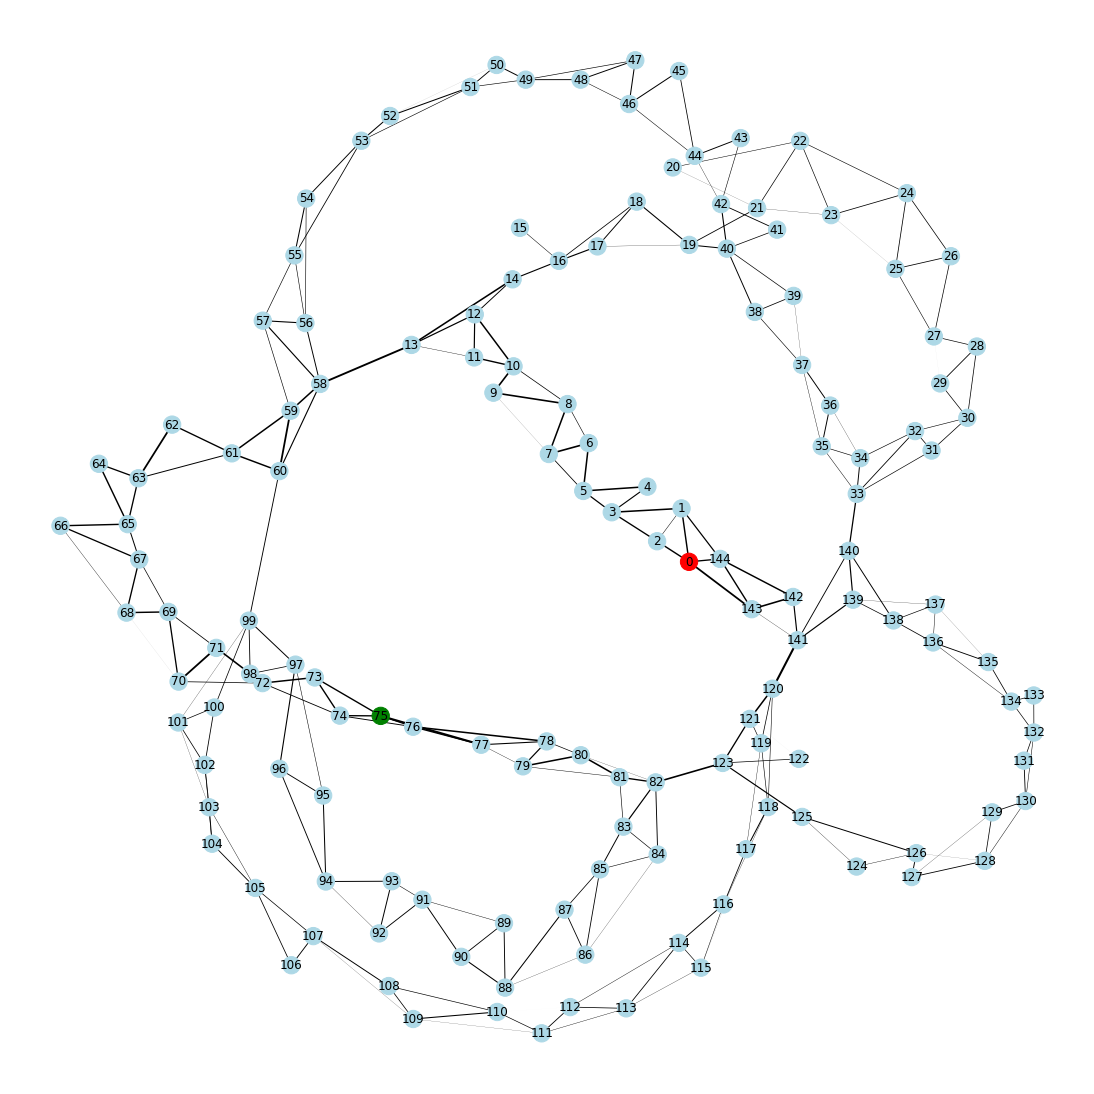

In [141]:
m = nx.adj_matrix(G)
p = np.ones_like(m.todense())
aco = ACO(start=graphstart, goal=graphgoal, pheromones=p, adjacency=m.todense())
aco.run(generations=1000, elitst_update=True, alpha=0.8, beta=0.2, reverse_ants=True, penalize_stuck=True)
aco.draw_pheromones(label=False)

In [142]:
widgets.interact(aco.draw_pheromones, label=False, width=15, height=15, show=widgets.fixed(True),prune=widgets.FloatSlider(value=0.1, min=0.0, max=0.50, step=0.05), generation=widgets.IntSlider(min=0,max=len(aco.pheromone_timeline)-1,step=1,value=0));

interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=0, description='generation',…

In [143]:
widgets.interact(aco.draw_pheromones, label=False, width=15, height=15, show=widgets.fixed(True),prune=widgets.FloatSlider(value=0.1, min=0.0, max=0.50, step=0.05), generation=widgets.IntSlider(min=0,max=len(aco.pheromone_timeline)-1,step=1,value=0));

interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=0, description='generation',…

In [57]:
aco.run(generations=2000, alpha=1, beta=0)

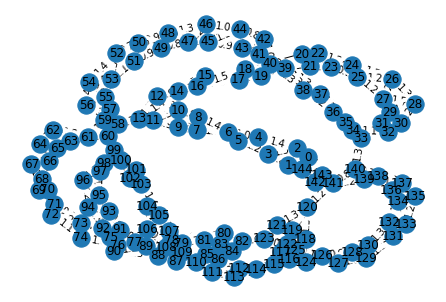

In [51]:
aco.draw_adjacency()

In [42]:
aco.best_path

[0, 143, 141, 120, 121, 123, 82, 84, 83, 81, 80, 79, 77, 75]

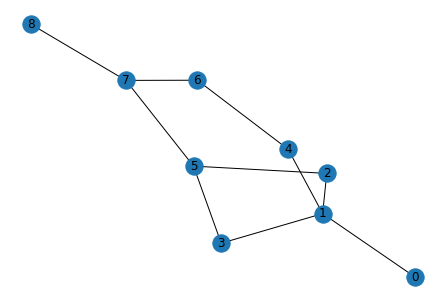

In [98]:
G = nx.Graph()
G.add_edge(0, 1, weight=1)
G.add_edge(1, 2, weight=1.5)
G.add_edge(1, 3, weight=1)
G.add_edge(3, 5, weight=1)
G.add_edge(1, 4, weight=3)
G.add_edge(2, 5, weight=1)
G.add_edge(4, 6, weight=1)
G.add_edge(5, 7, weight=1)
G.add_edge(6, 7, weight=3)
G.add_edge(7, 8, weight=1)
#G.add_edge(5, 9)
nx.draw(G, with_labels=True)
graphstart = 0
graphgoal = 8

m = nx.adj_matrix(G)
p = np.ones_like(m.todense())

In [209]:

class TimeExtendedACO(ACO):
    def __init__(self, timeframe=100, **kwargs):
        self.df = pd.DataFrame()
        ACO.__init__(self, **kwargs)
        self.run(generations=1000, **kwargs)
        self.extended_pheromones = np.zeros((timeframe, self.pheromones.shape[0], self.pheromones.shape[1]))
        self.timeframe = timeframe
        self.best_path = []
        self.best_distance = np.inf
        self.iteration = 0
        # create new ants outside of the current graph
        self.create_ants()
        self.arrived = 0
        self.timeout = 0
        for ant in self.ants:
            ant.forward = True
            ant.selection = self.tAco_selection
            ant.penalty = np.zeros_like(self.pheromones)
        for t in range(timeframe):
            self.extended_pheromones[t] = self.pheromones
     
    def tAco_selection_value(self, i, j, extended_pheromones=None, alpha=0.5, eps=0.1, beta=0.5, **kwargs):
        p = np.max([np.finfo(float).eps, self.pheromones[i,j]])
        p_ext = np.max([np.finfo(float).eps, extended_pheromones[i, j]])
        #print(f"tAcoSelection_value- {i}, {j}: p: {p}, p_ext{p_ext}")
        return  p**alpha * p_ext**beta + eps
    
    def extended_pheromones_sum(self):
        """normalized sum of the time extended pheromone values"""
        return self.normalize_(np.sum(self.extended_pheromones, axis=0))
    
    def tAco_selection(self, state, new, time=0, forward=True, **kwargs):
        """select the next action based on time extended pheromones
        forward: select based on current time-step pheromone matrix
        backward: select based on sum of time extended pheromones
        """
        #print(f"tAcoSelection- state: {state}, new: {new}, time: {time}")

        probs = {}
        if forward:
            probs = {k : self.tAco_selection_value(state, k, extended_pheromones=self.extended_pheromones[time], **kwargs) for k in new }
        else:
            probs = {k : self.tAco_selection_value(state, k, extended_pheromones=self.extended_pheromones_sum(), **kwargs) for k in new }
        
        #print(probs)
        
        cutoff = np.random.rand()
        s = sum(probs.values())
        x = new[-1]
        for k, v in probs.items():
            cutoff -= v / s
            if cutoff < 0:
                # print(f"tAcoSelection- {probs} -- selected: {k}")
                return k
        if cutoff > 0:
            print(f"cutoff:{cutoff} > 0 - should not happen")
            print(probs)
        return x
    
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize_(self, pheromones, gamma = 1, **kwargs):
        x = np.clip(np.inf, 0, pheromones)
        factor = gamma * pheromones.shape[0] / np.sum(x)
        return x * factor
    
    def extended_step(self, **kwargs):
        for ant in self.ants:
            if ant.forward:
                ant.step(selection=self.tAco_selection, allow_revisit=True, allow_wait=True, **kwargs)
            else:
                ant.step(allow_revisit=False, allow_wait=False, **kwargs)
            
    def run_extended(self, generations=1000, **kwargs):
        self.kwargs.update(kwargs)
        data = [self.df]
        for generation in range(generations):
            self.iteration += 1
            self.extended_step(**self.kwargs)
            self.extended_update_pheromones(**self.kwargs)
            self.extended_daemon_actions(**self.kwargs)
            data.append(pd.DataFrame({"iteration":self.iteration, "arrived": self.arrived, "timout":self.timeout, "shortest":self.best_distance}, index=[self.iteration]))
        self.df = pd.concat(data)
            
    def extended_daemon_actions(self, reverse_ants=True, penalty_factor=0.01, depenalize_long_running=True, **kwargs):
        """perform daemon actions
        * Reset ants that have arrived
        
        Keyword Arguments:
        reverse_ants -- if True the goal and start will be swapped before the ant is reset
        """
        for ant in self.ants:
            if ant.get_time() >= self.timeframe:
                if depenalize_long_running:
                    self.depenalize_path(ant, penalty_factor)
                ant.setup()
                self.timeout += 1
                #print("ant did not arrive")
                
            if ant.stuck:
                if ant.forward:
                    print("forward, should not be stuck")
                ant.setup()
            if ant.state == ant.goal:
                if ant.forward:
                    self.arrived += 1
                    print(f"ant arrived afer {ant.get_time()} steps: {ant.path} ")
                if ant.distance < self.best_distance:
                    self.best_distance = ant.distance
                    self.best_path = ant.path
                if reverse_ants:
                    ant.forward = not ant.forward
                    ant.goal, ant.start = ant.start, ant.goal
                    
                ant.setup()
        self.distance_timeline.append(self.best_distance)
    
    def been_there_done_that_penalty(self, path):
        """add fixed amount of penalty for every edge and every node visited"""
        penalty = np.zeros_like(self.pheromones)
        for n1, n2 in zip(path[1:], path[:-1]):
            penalty[n1, n2] = -1
            penalty[n2, n1] = -1
            penalty[n1, n1] = -1
        return penalty
            
    
    def extended_online_pheromone_update(self, penalty_factor = 0.01, **kwargs):
        """lower the pheromones in future nodes, where the ant has alreadd visited in the past"""
        for ant in self.ants:
            if ant.forward:
                for t in range(ant.get_time(), self.timeframe):
                    self.extended_pheromones[t] = self.extended_pheromones[t] + penalty_factor * self.been_there_done_that_penalty(ant.path)
    
    def depenalize_path(self, ant, penalty_factor, **kwargs):
        """reverse the penalty of an ant"""
        for t in range(0,ant.get_time()):
            for t2 in range(t, self.timeframe):
                penalty = penalty_factor * self.been_there_done_that_penalty(ant.path[:t])
                self.extended_pheromones[t2] -= penalty
                    
                    
        
    
    def extended_delayed_online_pheromone_update(self, penalty_factor = 0.01, **kwargs):
        """reverse the penalty for moving backward and put more pheromones on the path"""
        for ant in self.ants:
           
            if ant.forward and ant.state==ant.goal:
                # in case the goal is reached, reverse the penalty for moving backwards, for all time steps
                self.depenalize_path(ant, penalty_factor)
                for t in range(0,ant.get_time()):
                    # put pheromones on the path depending on path fitness
                    amount = 1 / ant.distance + 1/ant.get_time()
                    self.extended_pheromones[t][ant.path[t], ant.path[t+1]] += amount
                    self.extended_pheromones[t][ant.path[t+1], ant.path[t]] += amount
            elif not ant.forward and ant.state==ant.goal:
                amount = 1 / ant.distance
                for i, j in zip(ant.path[1:], ant.path[:-1]):
                    self.pheromones[i, j] += amount
                    self.pheromones[j, i] += amount
                

    def extended_update_pheromones(self, node_pheromon=True, evaporation_method="normalize", log_pheromones=True, penalize_stuck=False, elitist_update=False, **kwargs):
        """updates the pheromone matrix
    
        Keyword Arguments:
        delayed_update -- bool telling to perform the pheromone update after each step or when the ant reaches the goal
        evaporation_method -- tell the algorithm how to perform evaporation ("normalize" or "evaporate")
        gamma -- rate of evaporation (depends on evaporation_method)
        """
        
        # the online pheromone update penalizes already visited nodes in future time-steps the penalty is lifted once the ant reaches the goal
        self.extended_online_pheromone_update(**kwargs)
        
        # the delayed update reverses the penalty once the ant reaches the goal and puts extra pheromones on the travelled path (depending on fitness)
        self.extended_delayed_online_pheromone_update(**kwargs)
        
        if elitist_update:
            amount = 1 / self.best_distance / self.num_ants
            for i in range(len(self.best_path) - 1):
                self.pheromones[self.best_path[i], self.best_path[i+1]] += amount
                self.pheromones[self.best_path[i+1], self.best_path[i]] += amount
                
        
        # evaporation
        if evaporation_method == "normalize":
            self.pheromones = self.normalize_(self.pheromones)
            for t in range(self.timeframe):
                self.extended_pheromones[t] = self.normalize_(self.extended_pheromones[t])
        elif evaporation_method == "evaporate":
            self.evaporate(**kwargs)
        
        if penalize_stuck:
            self.penalize_stuck(**kwargs)
        
        #np.clip( self.pheromones,0, np.inf, out=self.pheromones)
        if log_pheromones:
            self.pheromone_timeline.append(self.pheromones.copy())
            
        
    def draw_extended_pheromones(self, label=True, time=-1, width=15, height=15, thickness=3, show=True, prune=0):
        plt.figure(figsize=(width,height))
        G = nx.from_numpy_matrix(self.extended_pheromones[time])
        Ga = nx.from_numpy_matrix(self.adjacency)
        pos = nx.kamada_kawai_layout(Ga)
        weight = nx.get_edge_attributes(G,'weight')
        node_colors = ["lightblue" for _ in range(self.pheromones.shape[0])]
        node_colors[self.start] = "red"
        node_colors[self.goal] = "green"
        labels = { k : f"{v:.2f}" for k, v in weight.items()}
        width = [(max(prune, w['weight']) - prune) * thickness for u, v, w in G.edges(data=True)]
        nx.draw(G,pos=pos,with_labels=True, width=width, node_color=node_colors)
        if label:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
            
        if show:
            plt.show()
    

In [210]:
tAco = TimeExtendedACO(adjacency=m.todense(), pheromones=np.ones_like(m.todense()), start=graphstart, goal=graphgoal, timeframe=50)
tAco.run_extended(generations=1000, depenalize_long_running=False)

ant arrived afer 26 steps: [0, 144, 143, 142, 141, 139, 138, 136, 136, 135, 134, 133, 131, 129, 127, 125, 124, 122, 123, 82, 82, 81, 80, 79, 77, 76, 75] 
ant arrived afer 48 steps: [0, 2, 3, 1, 144, 143, 142, 141, 120, 118, 117, 116, 115, 115, 114, 112, 113, 111, 109, 108, 106, 106, 104, 105, 103, 101, 102, 100, 99, 99, 97, 95, 96, 94, 92, 91, 91, 89, 90, 88, 87, 86, 86, 84, 82, 80, 78, 76, 75] 
ant arrived afer 28 steps: [0, 143, 143, 141, 142, 144, 1, 3, 4, 6, 5, 7, 9, 11, 13, 58, 57, 59, 60, 61, 63, 65, 66, 68, 69, 70, 72, 73, 75] 
ant arrived afer 38 steps: [0, 2, 4, 3, 5, 7, 8, 10, 12, 11, 13, 58, 57, 59, 60, 99, 101, 102, 100, 98, 97, 97, 96, 94, 92, 90, 88, 88, 87, 86, 84, 85, 83, 82, 80, 78, 79, 77, 75] 
ant arrived afer 43 steps: [0, 0, 143, 142, 141, 120, 120, 118, 119, 117, 116, 114, 113, 113, 112, 111, 109, 108, 106, 105, 103, 101, 100, 100, 99, 60, 61, 61, 62, 63, 65, 64, 64, 66, 68, 69, 71, 70, 72, 72, 74, 76, 77, 75] 
ant arrived afer 32 steps: [0, 2, 1, 3, 4, 6, 8, 10, 

In [224]:
tAco.run_extended(generations=10000)

ant arrived afer 12 steps: [0, 143, 142, 141, 120, 121, 123, 82, 80, 78, 76, 74, 75] 
ant arrived afer 48 steps: [0, 144, 143, 141, 120, 121, 119, 118, 117, 115, 114, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 103, 101, 100, 100, 100, 99, 98, 96, 96, 97, 95, 93, 92, 90, 89, 88, 87, 85, 84, 82, 83, 81, 80, 80, 78, 79, 77, 75] 
ant arrived afer 21 steps: [0, 143, 141, 120, 118, 116, 115, 117, 119, 119, 121, 122, 124, 125, 123, 123, 82, 81, 80, 78, 76, 75] 
ant arrived afer 33 steps: [0, 1, 2, 3, 4, 6, 5, 7, 9, 11, 10, 12, 13, 13, 13, 13, 58, 60, 59, 61, 63, 63, 64, 66, 65, 67, 68, 70, 69, 69, 71, 72, 73, 75] 
ant arrived afer 18 steps: [0, 143, 141, 120, 121, 123, 82, 84, 85, 83, 81, 80, 78, 77, 76, 74, 72, 73, 75] 
ant arrived afer 36 steps: [0, 143, 142, 141, 120, 119, 117, 116, 114, 113, 112, 110, 109, 108, 107, 105, 104, 104, 102, 100, 98, 99, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 71, 72, 74, 75] 
ant arrived afer 21 steps: [0, 2, 4, 5, 3, 3, 1, 144, 143, 142, 141, 120, 

In [225]:
widgets.interact(tAco.draw_pheromones, label=False, width=15, height=15, show=widgets.fixed(True),prune=widgets.FloatSlider(value=0.1, min=0.0, max=0.50, step=0.05), generation=widgets.IntSlider(min=0,max=len(tAco.pheromone_timeline)-1,step=1,value=0));

interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=0, description='generation',…

In [226]:
widgets.interact(tAco.draw_extended_pheromones, label=False, width=15, height=15, show=widgets.fixed(True),prune=widgets.FloatSlider(value=0.1, min=0.0, max=0.50, step=0.05), time=widgets.IntSlider(min=0,max=tAco.timeframe-1,step=1,value=0));

interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=0, description='time', max=4…

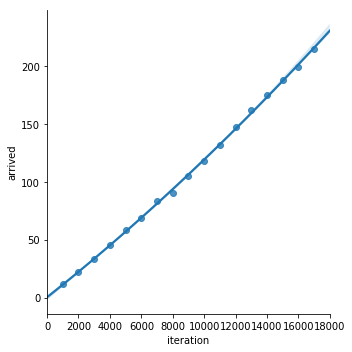

In [231]:
sns.lmplot(data=tAco.df.loc[tAco.df.iteration % 1000 == 0], x="iteration", y="arrived", order=2)

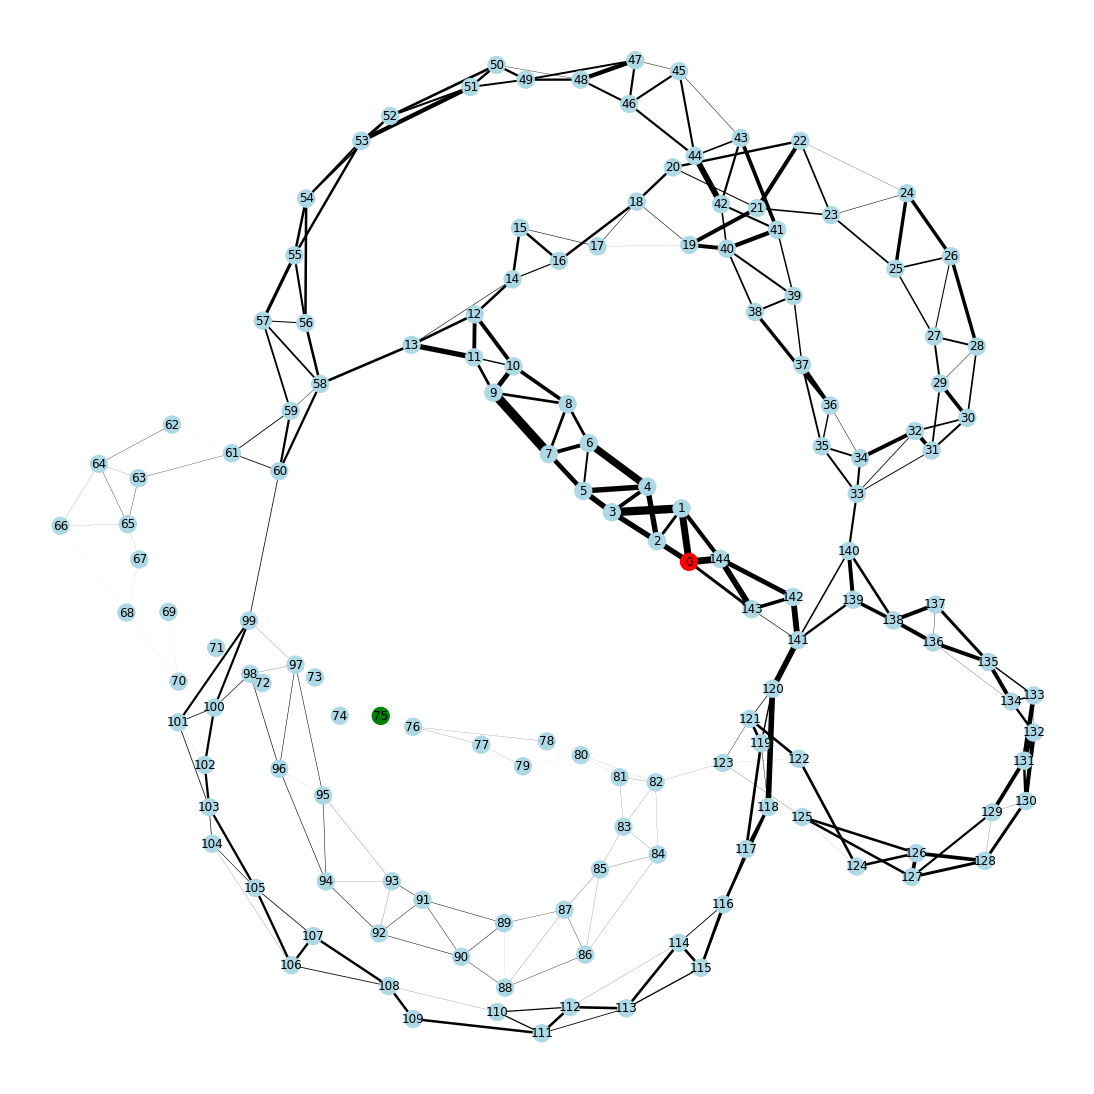

In [182]:
tAco.draw_extended_pheromones(label=False)

In [175]:
x = tAco.extended_pheromones_sum()
tAco.ants[0].stuck

False

In [15]:
x.shape

(10, 10)

In [16]:
tAco.extended_step(selection=tAco.tAco_selection)

TypeError: step() got multiple values for keyword argument 'selection'

In [19]:
tAco.ants[0].adjacency

matrix([[0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [1. , 0. , 1.5, 1. , 0. , 3. , 0. , 0. , 0. , 0. ],
        [0. , 1.5, 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 1. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 1. , 1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [0. , 3. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 1. , 0. , 3. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 1. , 0. , 3. , 0. , 1. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ]])